# GeneModule Identified

In omicverse, we prepared two methods to identify the gene module, one is `cNMF`, the other one is `hospot`.

In [1]:
import scanpy as sc
import omicverse as ov
ov.style(font_path='Arial')

%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 1
    • [CUDA 0] NVIDIA H100 80GB HBM3
      Memory: 79.1 GB | Compute: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.9rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Loading dataset

Here, we use the dentategyrus dataset as an example for cNMF or Hospot.

In [2]:
adata=ov.datasets.pancreatic_endocrinogenesis()

🔍 Downloading data to ./data/endocrinogenesis_day15.h5ad
⚠️ File ./data/endocrinogenesis_day15.h5ad already exists
 Loading data from ./data/endocrinogenesis_day15.h5ad
✅ Successfully loaded: 3696 cells × 27998 genes


In [3]:
%%time
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata

🔍 [2026-01-07 17:06:35] Running preprocessing in 'cpu' mode...
Begin robust gene identification
    After filtration, 17750/27998 genes are kept.
    Among 17750 genes, 16426 genes are robust.
✅ Robust gene identification completed successfully.
Begin size normalization: shiftlog and HVGs selection pearson

🔍 Count Normalization:
   Target sum: 500000.0
   Exclude highly expressed: True
   Max fraction threshold: 0.2
   ⚠️ Excluding 1 highly-expressed genes from normalization computation
   Excluded genes: ['Ghrl']

✅ Count Normalization Completed Successfully!
   ✓ Processed: 3,696 cells × 16,426 genes
   ✓ Runtime: 0.25s

🔍 Highly Variable Genes Selection (Experimental):
   Method: pearson_residuals
   Target genes: 2,000
   Theta (overdispersion): 100

✅ Experimental HVG Selection Completed Successfully!
   ✓ Selected: 2,000 highly variable genes out of 16,426 total (12.2%)
   ✓ Results added to AnnData object:
     • 'highly_variable': Boolean vector (adata.var)
     • 'highly_vari

AnnData object with n_obs × n_vars = 3696 × 16426
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'distances', 'connectivities'

In [4]:
ov.pp.scale(adata)
ov.pp.pca(adata)

computing PCA🔍
    with n_comps=50
   🖥️ Using sklearn PCA for CPU computation
   🖥️ sklearn PCA backend: CPU computation
    finished✅ (0:00:02)


<Axes: title={'center': 'Celltypes'}, xlabel='X_umap1', ylabel='X_umap2'>

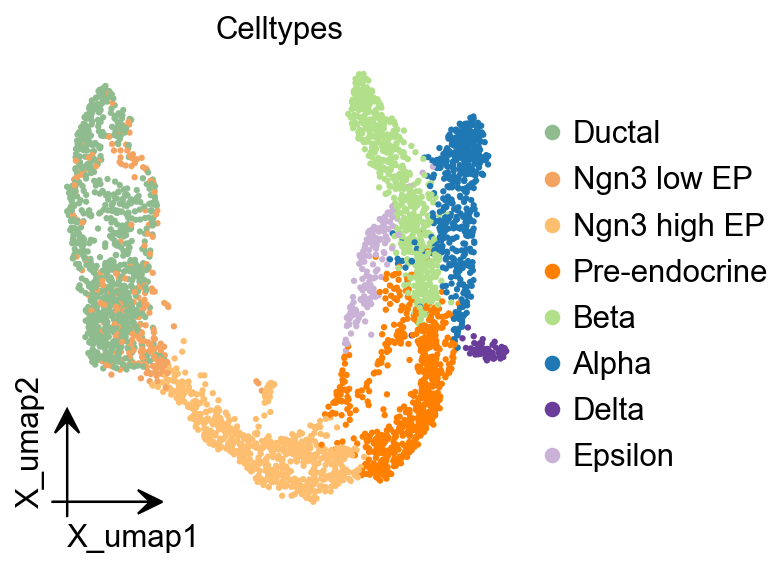

In [5]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(4,4))
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=['clusters'],
    frameon='small',
    title="Celltypes",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    #size=10,
    ax=ax,
    #legend_loc=True, 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
)

## Consensus Non-negative Matrix factorization (cNMF)

cNMF is an analysis pipeline for inferring gene expression programs from single-cell RNA-Seq (scRNA-Seq) data.

It takes a count matrix (N cells X G genes) as input and produces a (K x G) matrix of gene expression programs (GEPs) and a (N x K) matrix specifying the usage of each program for each cell in the data. You can read more about the method in the [github](https://github.com/dylkot/cNMF) and check out examples on dentategyrus.

- Dylan KotliarAdrian VeresM Aurel NagyShervin TabriziEran HodisDouglas A MeltonPardis C Sabeti (2019) Identifying gene expression programs of cell-type identity and cellular activity with single-cell RNA-Seq eLife 8:e43803.

### Initialize and Training model

In omicverse, you can set `use_gpu=True` to perform the NMF analysis using torchnmf package, it's easy to install using `pip install torchnmf`. But it should be noticed the accurancy is different if you use `use_gpu=True` mode.

In [7]:
import numpy as np
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = ov.single.cNMF(
    adata,components=np.arange(5,15), n_iter=20, 
    seed=14, num_highvar_genes=2000,
    output_dir=None, name='pancrea_cNMF',use_gpu=True
)

normalizing counts per cell
    finished (0:00:00)


In [8]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=1)

🚀 Running NMF on GPU (device 0)
Running 200 factorization iterations for worker 0...


100%|██████████| 200/200 [00:06<00:00, 28.69it/s]

✓ Worker 0 completed 200 iterations. Total in memory: 200


if u want to accerlate the calculation, you can try the code below

In [ ]:
#cnmf_obj.factorize(worker_i=0, total_workers=2)
#cnmf_obj.factorize(worker_i=1, total_workers=2)

In [9]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=5.
  Found all 20 iterations for k=5
Combining factorizations for k=6.
  Found all 20 iterations for k=6
Combining factorizations for k=7.
  Found all 20 iterations for k=7
Combining factorizations for k=8.
  Found all 20 iterations for k=8
Combining factorizations for k=9.
  Found all 20 iterations for k=9
Combining factorizations for k=10.
  Found all 20 iterations for k=10
Combining factorizations for k=11.
  Found all 20 iterations for k=11
Combining factorizations for k=12.
  Found all 20 iterations for k=12
Combining factorizations for k=13.
  Found all 20 iterations for k=13
Combining factorizations for k=14.
  Found all 20 iterations for k=14


In [9]:
cnmf_obj.save('test/cnmf_obj.pkl')

✓ cNMF object saved to: test/cnmf_obj.pkl
  - 200 factorization iterations
  - 10 merged spectra (K values)
  - 0 consensus results


In [6]:
cnmf_obj.load('test/cnmf_obj.pkl')

📂 Load Operation:
   Source path: test/cnmf_obj.pkl
   Using: pickle
   ✅ Successfully loaded!
   Loaded object type: cNMF
────────────────────────────────────────────────────────────


### Compute the stability and error at each choice of K to see if a clear choice jumps out.

Please note that the maximum stability solution is not always the best choice depending on the application. However it is often a good starting point even if you have to investigate several choices of K

In [10]:
sil_data = cnmf_obj.calculate_silhouette_k(k=7, density_threshold=2.0)

print(f"Average silhouette score: {sil_data['avg_silhouette']:.4f}")
print(f"Per-sample scores: {sil_data['silhouette_values']}")
print(f"Cluster labels: {sil_data['cluster_labels']}")

Average silhouette score: 0.6299
Per-sample scores: [0.7106916  0.5630814  0.9380699  0.9647325  0.7674971  0.6231896
 0.7462224  0.37565622 0.6270655  0.06985006 0.57842237 0.7953116
 0.6916376  0.78109527 0.7101993  0.55603576 0.7441653  0.75451505
 0.5479283  0.9625558  0.39097318 0.43278462 0.97507685 0.60460097
 0.7781605  0.67471343 0.53983855 0.76693016 0.64284235 0.41358513
 0.7894957  0.5756324  0.9714798  0.54308915 0.73912    0.5916759
 0.29305577 0.5943038  0.9639678  0.75087273 0.4957365  0.7721111
 0.5499817  0.5790103  0.73023146 0.588068   0.77418405 0.18887511
 0.3828089  0.71155    0.93825644 0.66316015 0.7878561  0.9744356
 0.7274356  0.628735   0.96383363 0.63263124 0.64927    0.17515936
 0.7908563  0.59846324 0.67699015 0.37909067 0.7533861  0.27464965
 0.94846934 0.56372494 0.62612045 0.39772192 0.4309683  0.50130105
 0.5352081  0.2945753  0.7588943  0.7905221  0.7286009  0.94101614
 0.5963504  0.60703915 0.6570392  0.17053658 0.7238535  0.63654566
 0.164855   0.6

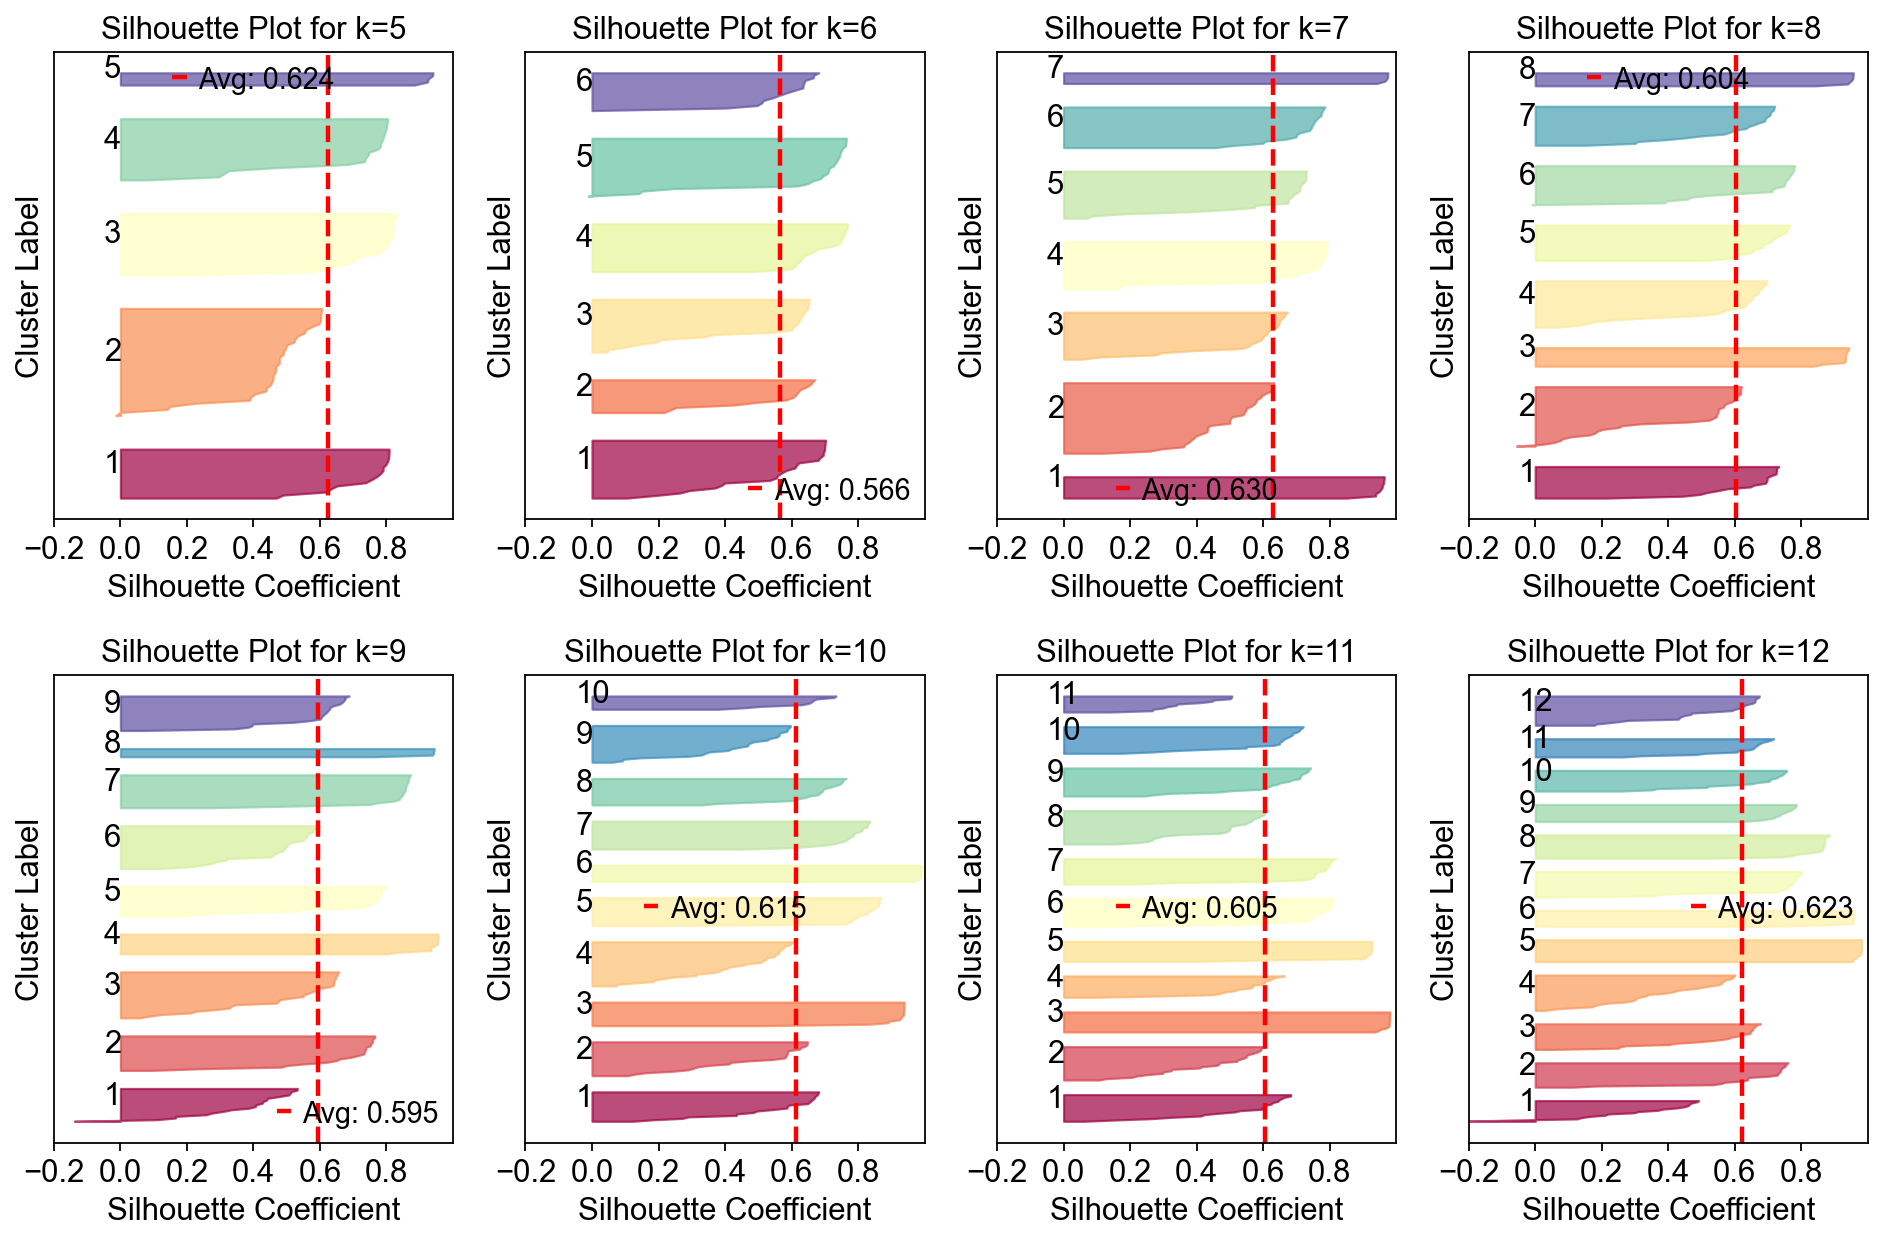

In [11]:
fig, axes = plt.subplots(2,4,figsize=(12,8))
for k,ax in zip(np.arange(5,15),axes.flatten()):
    cnmf_obj.plot_silhouette_for_k(
        k=k,
        density_threshold=2.0,
        show_avg=True,
        cmap='Spectral',ax=ax
    )
plt.tight_layout()

Calculating silhouette scores for K selection...


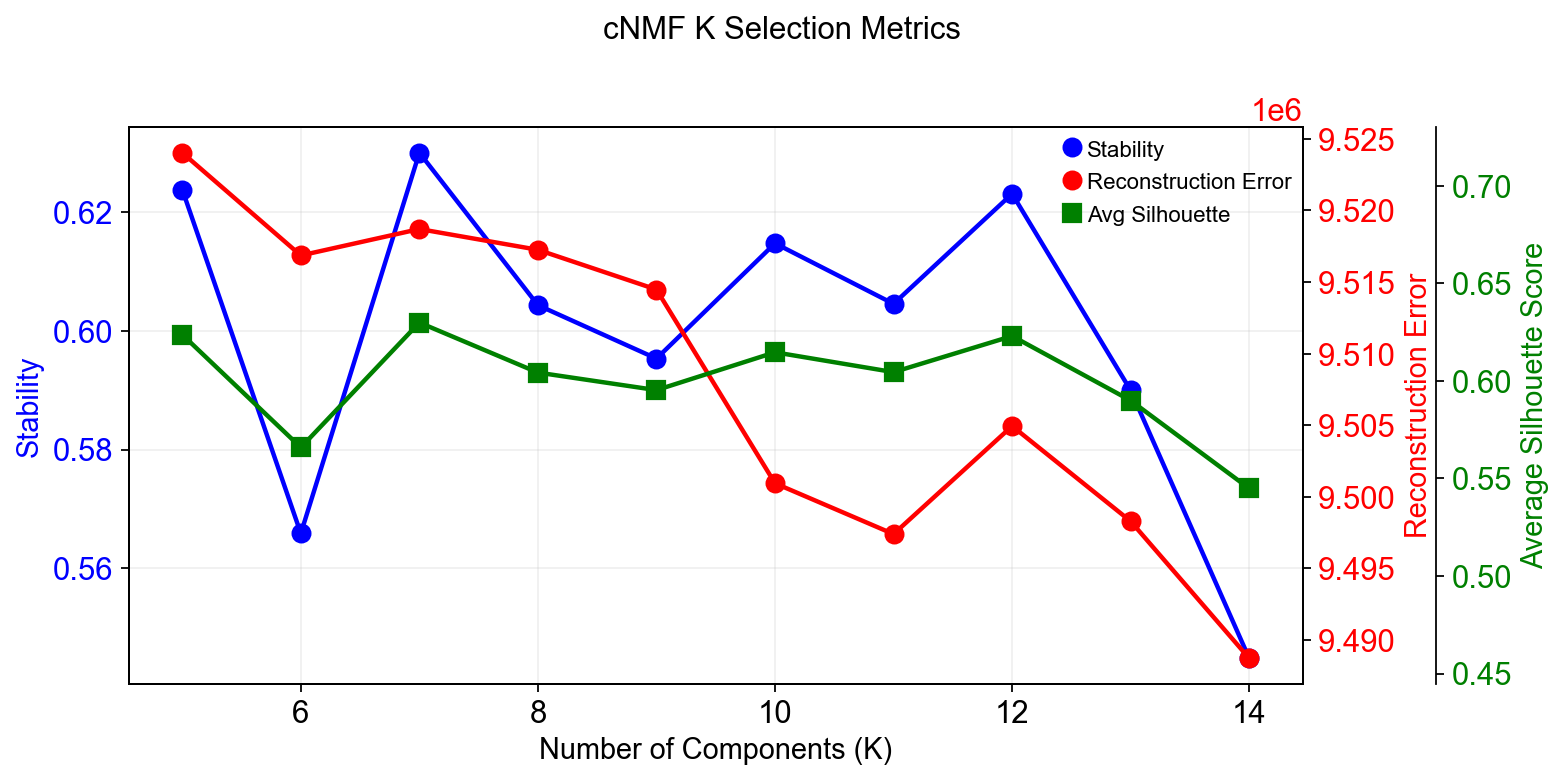

In [12]:
fig=cnmf_obj.k_selection_plot(close_fig=False)

In this range, K=12 gave the most stable solution so we will begin by looking at that.

The next step computes the consensus solution for a given choice of K. We first run it without any outlier filtering to see what that looks like. Setting the density threshold to anything >= 2.00 (the maximum possible distance between two unit vectors) ensures that nothing will be filtered.

Then we run the consensus with a filter for outliers determined based on inspecting the histogram of distances between components and their nearest neighbors

In [13]:
selected_K = 12
density_threshold = 2.00

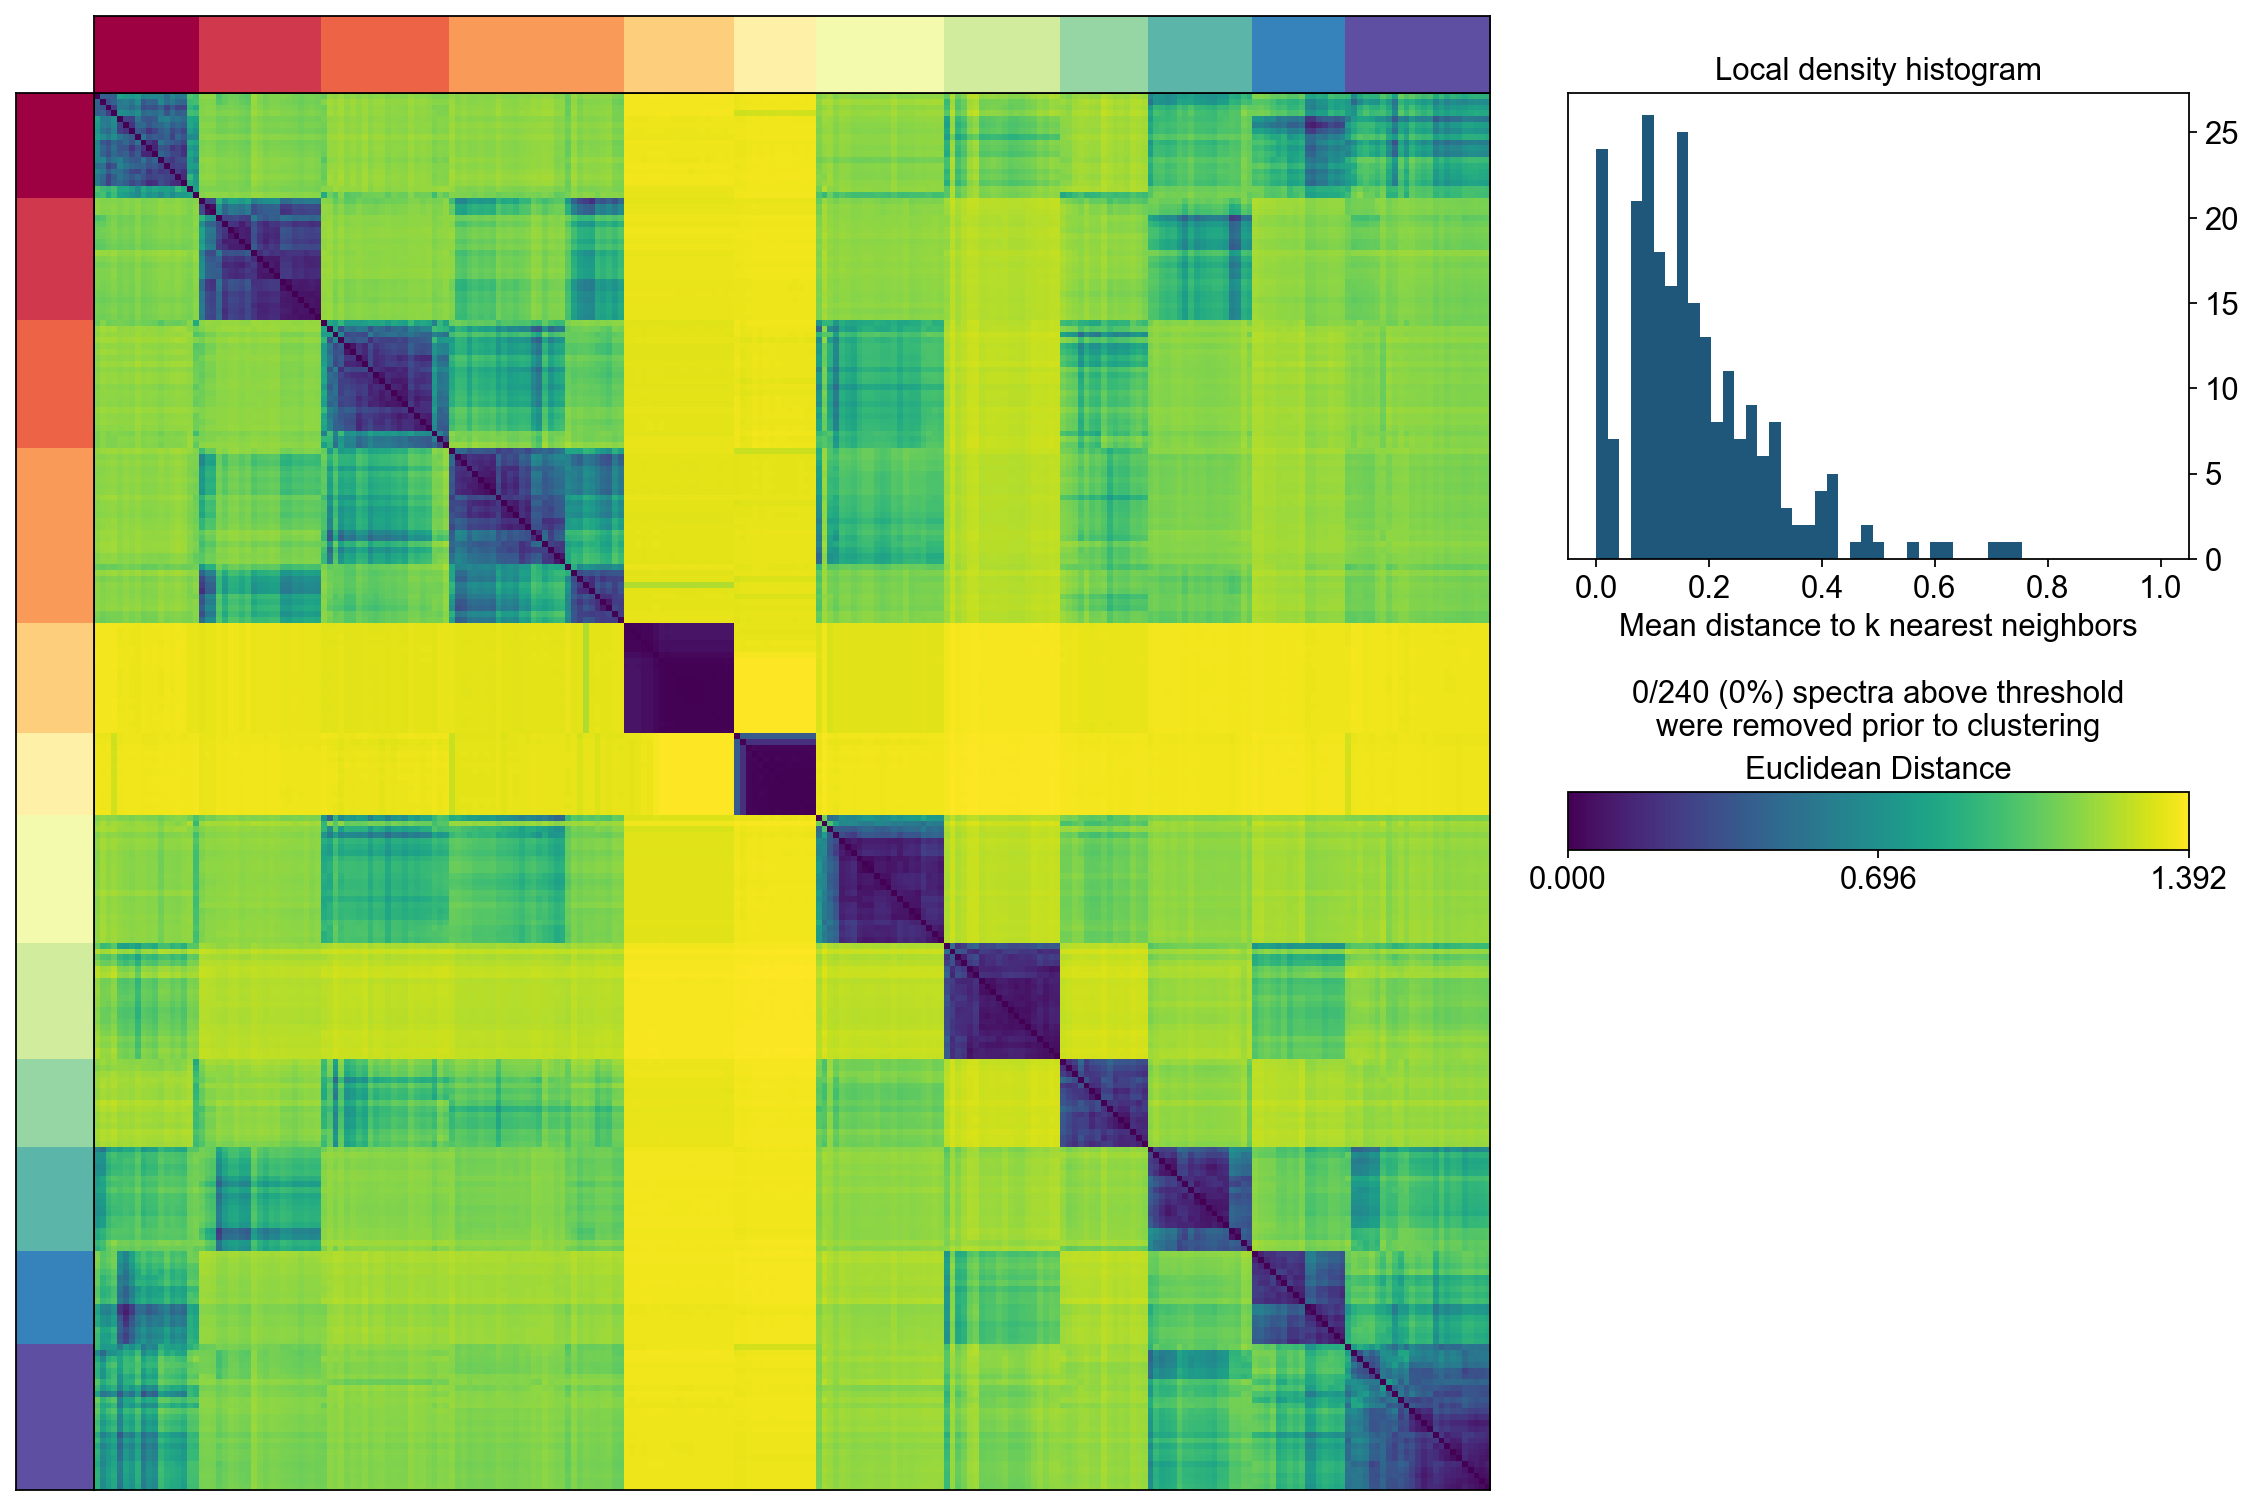

In [14]:
cnmf_obj.consensus(k=selected_K, 
                   density_threshold=density_threshold, 
                   show_clustering=True, 
                   close_clustergram_fig=False)

The above consensus plot shows that there is a substantial degree of concordance between the replicates with a few outliers. An outlier threshold of 0.1 seems appropriate

In [15]:
density_threshold = 0.10

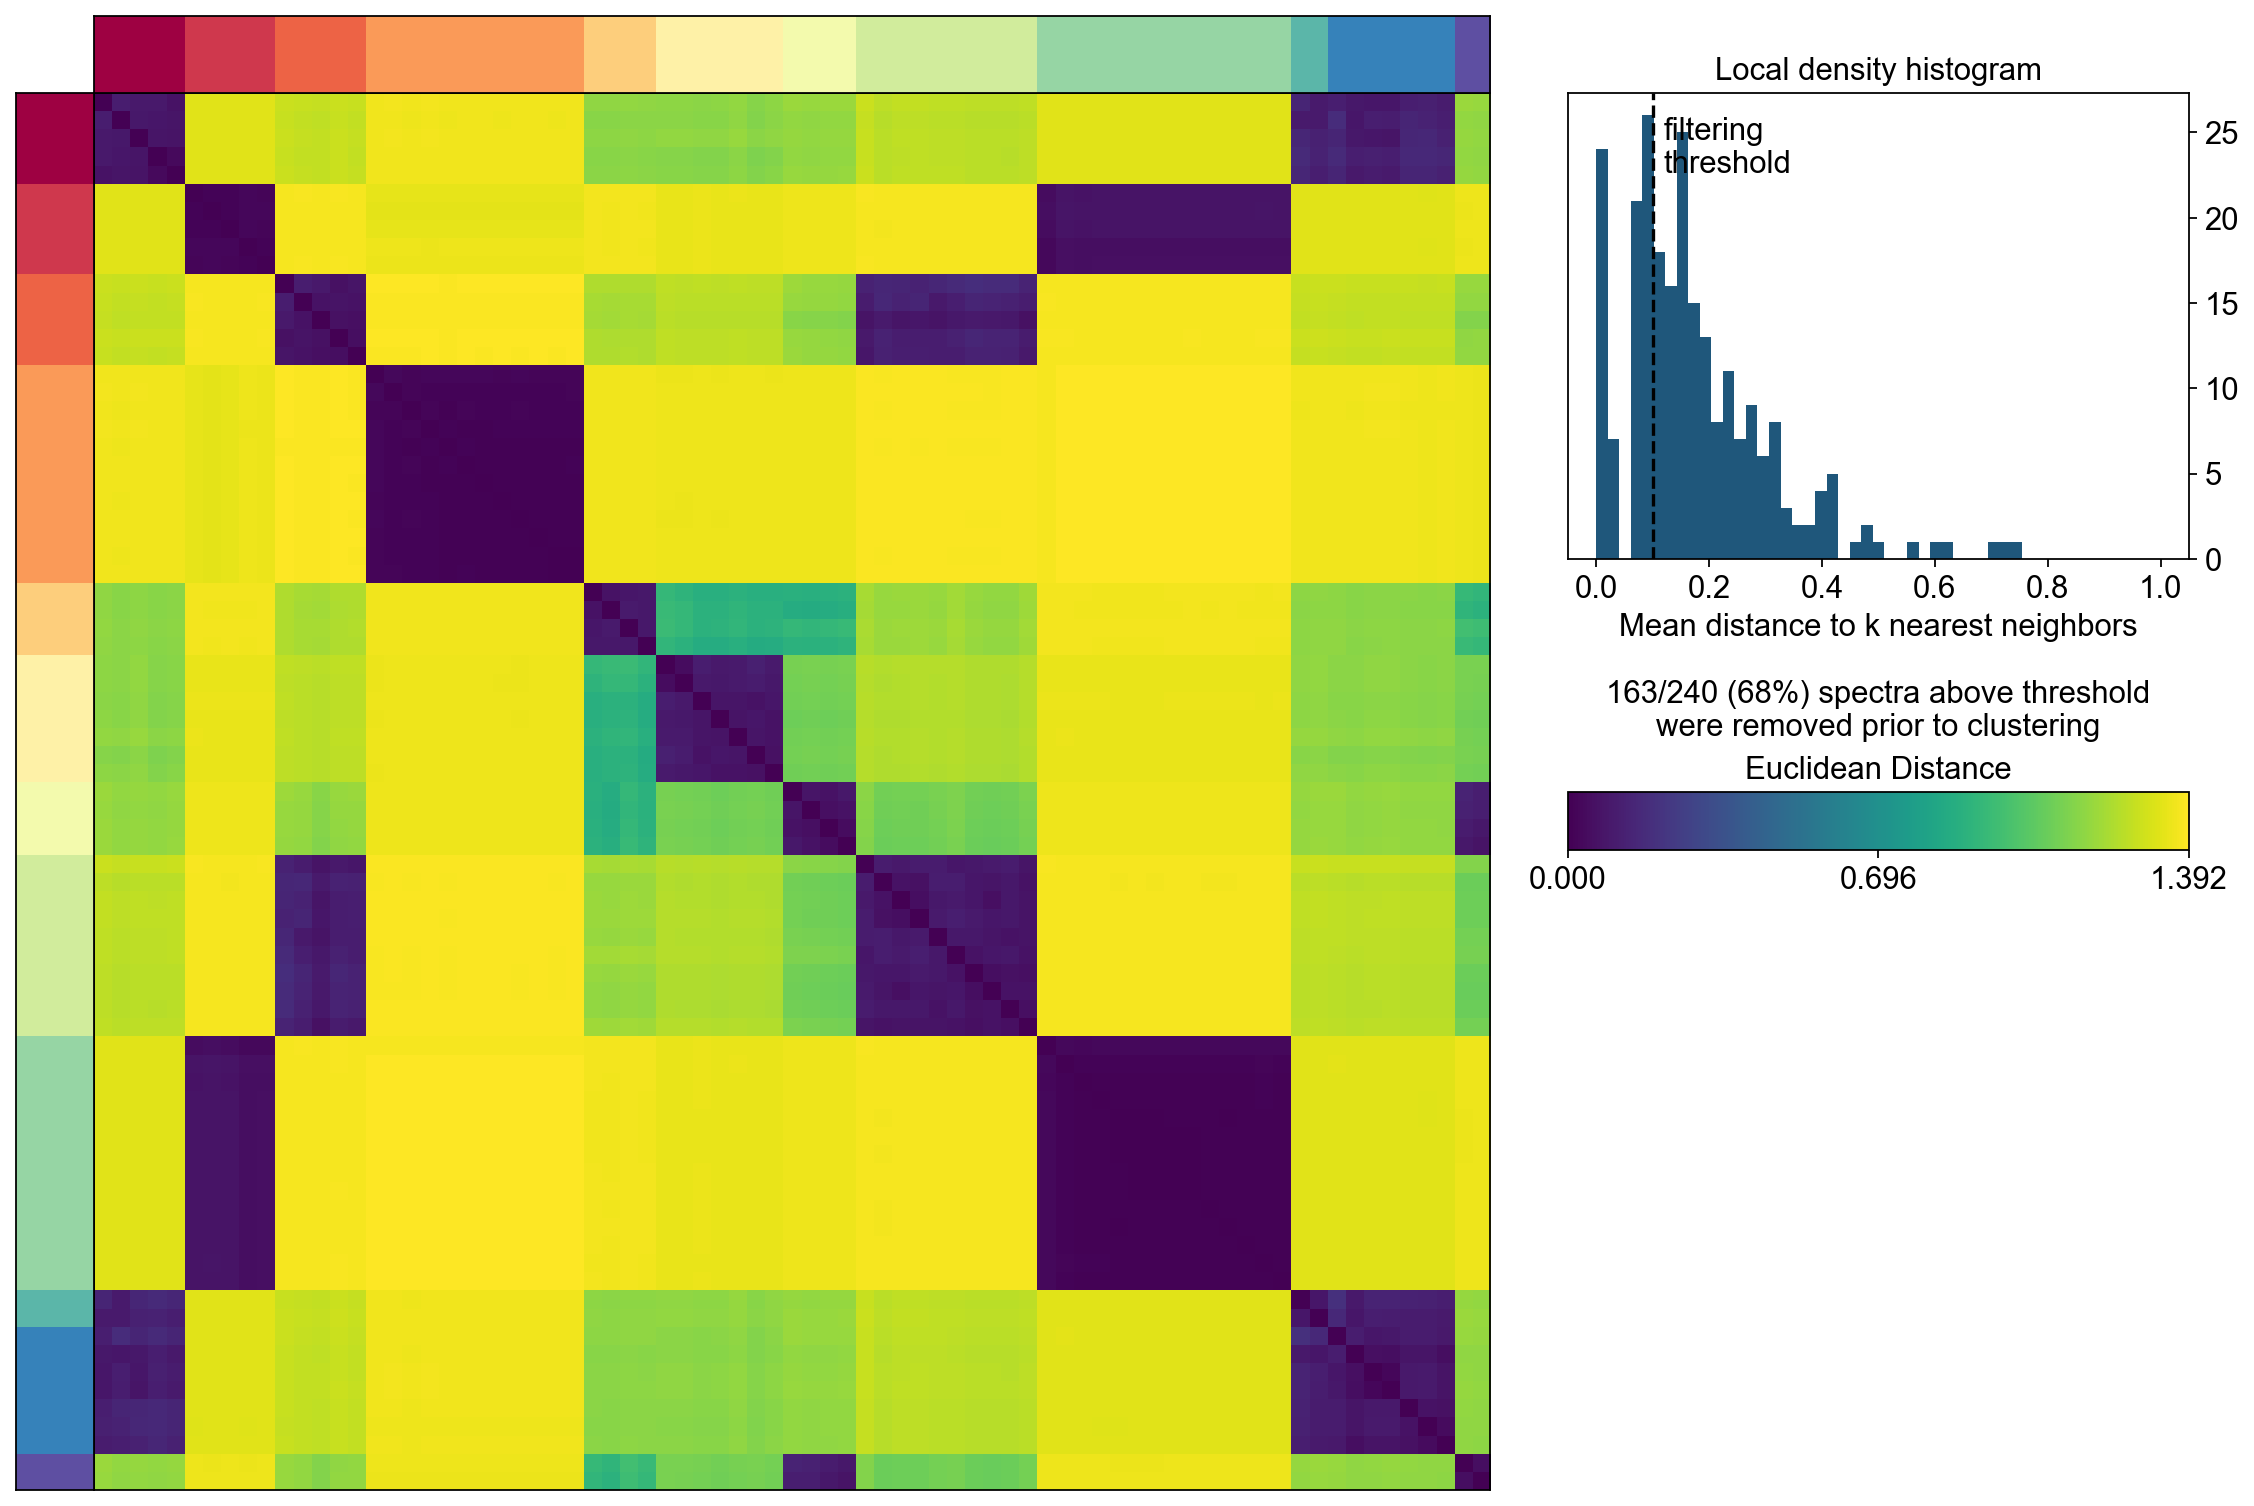

In [16]:
cnmf_obj.consensus(k=selected_K, 
                   density_threshold=density_threshold, 
                   show_clustering=True, 
                   close_clustergram_fig=False)

### Visualization the result

[Text(1, 0.0, '0.000'),
 Text(1, 0.6961943507194519, '0.696'),
 Text(1, 1.3923887014389038, '1.392')]

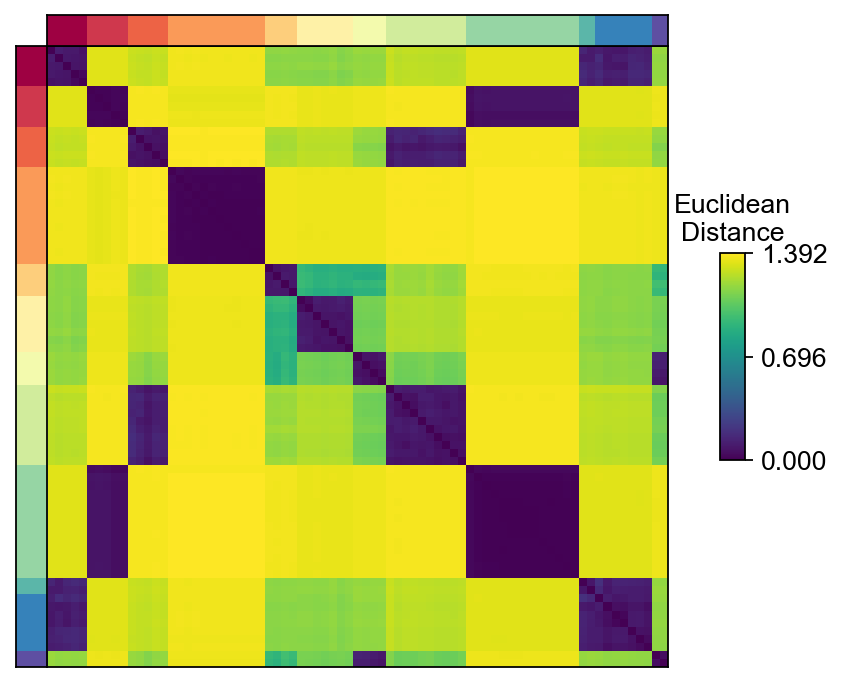

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects

from matplotlib import gridspec
import matplotlib.pyplot as plt

width_ratios = [0.2, 4, 0.5, 10, 1]
height_ratios = [0.2, 4]
fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), fig,
                        0.01, 0.01, 0.98, 0.98,
                       height_ratios=height_ratios,
                       width_ratios=width_ratios,
                       wspace=0, hspace=0)
            
D = cnmf_obj.topic_dist[cnmf_obj.spectra_order, :][:, cnmf_obj.spectra_order]
dist_ax = fig.add_subplot(gs[1,1], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True)
dist_im = dist_ax.imshow(D, interpolation='none', cmap='viridis',
                         aspect='auto', rasterized=True)

left_ax = fig.add_subplot(gs[1,0], xscale='linear', yscale='linear', xticks=[], yticks=[],
                xlabel='', ylabel='', frameon=True)
left_ax.imshow(cnmf_obj.kmeans_cluster_labels.values[cnmf_obj.spectra_order].reshape(-1, 1),
                            interpolation='none', cmap='Spectral', aspect='auto',
                            rasterized=True)

top_ax = fig.add_subplot(gs[0,1], xscale='linear', yscale='linear', xticks=[], yticks=[],
                xlabel='', ylabel='', frameon=True)
top_ax.imshow(cnmf_obj.kmeans_cluster_labels.values[cnmf_obj.spectra_order].reshape(1, -1),
                  interpolation='none', cmap='Spectral', aspect='auto',
                    rasterized=True)

cbar_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1, 2],
                                   wspace=0, hspace=0)
cbar_ax = fig.add_subplot(cbar_gs[1,2], xscale='linear', yscale='linear',
    xlabel='', ylabel='', frameon=True, title='Euclidean\nDistance')
cbar_ax.set_title('Euclidean\nDistance',fontsize=12)
vmin = D.min().min()
vmax = D.max().max()
fig.colorbar(dist_im, cax=cbar_ax,
        ticks=np.linspace(vmin, vmax, 3),
        )
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=12)

Text(0.5, 1.0, 'Local density histogram')

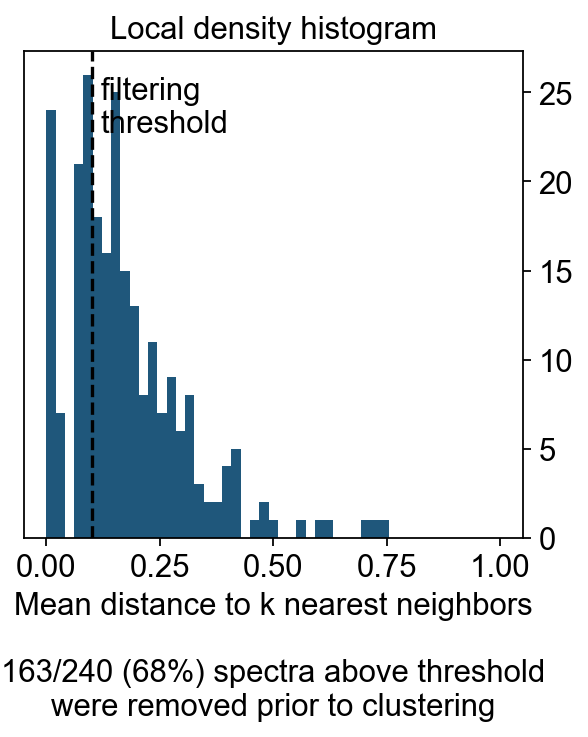

In [18]:
density_filter = cnmf_obj.local_density.iloc[:, 0] < density_threshold
fig, hist_ax = plt.subplots(figsize=(4,4))

#hist_ax = fig.add_subplot(hist_gs[0,0], xscale='linear', yscale='linear',
 #   xlabel='', ylabel='', frameon=True, title='Local density histogram')
hist_ax.hist(cnmf_obj.local_density.values, bins=np.linspace(0, 1, 50))
hist_ax.yaxis.tick_right()

xlim = hist_ax.get_xlim()
ylim = hist_ax.get_ylim()
if density_threshold < xlim[1]:
    hist_ax.axvline(density_threshold, linestyle='--', color='k')
    hist_ax.text(density_threshold  + 0.02, ylim[1] * 0.95, 'filtering\nthreshold\n\n', va='top')
hist_ax.set_xlim(xlim)
hist_ax.set_xlabel('Mean distance to k nearest neighbors\n\n%d/%d (%.0f%%) spectra above threshold\nwere removed prior to clustering'%(sum(~density_filter), len(density_filter), 100*(~density_filter).mean()))
hist_ax.set_title('Local density histogram')

### Explode the cNMF result

We can load the results for a cNMF run with a given K and density filtering threshold like below

In [19]:
result_dict = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)


In [20]:
result_dict['usage_norm'].head()

cNMF_1    cNMF_2    cNMF_3    cNMF_4    cNMF_5    cNMF_6  \
index                                                                          
AAACCTGAGAGGGATA  0.052900  0.557367  0.000422  0.021016  0.006930  0.003447   
AAACCTGAGCCTTGAT  0.020833  0.000962  0.570114  0.043898  0.000887  0.173351   
AAACCTGAGGCAATTA  0.000142  0.306285  0.050380  0.000632  0.017096  0.028461   
AAACCTGCATCATCCC  0.011620  0.000740  0.142481  0.011996  0.002794  0.510735   
AAACCTGGTAAGTGGC  0.543322  0.149150  0.003397  0.199798  0.000105  0.011512   

                    cNMF_7    cNMF_8    cNMF_9   cNMF_10   cNMF_11   cNMF_12  
index                                                                         
AAACCTGAGAGGGATA  0.079662  0.082491  0.000638  0.005284  0.030603  0.159242  
AAACCTGAGCCTTGAT  0.007137  0.132107  0.004638  0.000670  0.029395  0.016007  
AAACCTGAGGCAATTA  0.017249  0.053764  0.000810  0.005584  0.131687  0.387909  
AAACCTGCATCATCCC  0.001547  0.281503  0.003506  0.025785  0.005863  0.001429  
AAACCTGGTAAGTGGC  0.023303  0.000721  0.003200  0.022096  0.025705  0.017692

In [21]:
result_dict['gep_scores'].head()

1         2         3         4         5         6   \
index                                                                       
Xkr4          -0.007757 -0.001951  0.010988  0.000303  0.000153 -0.006076   
Mrpl15        -0.004883  0.017592 -0.018511 -0.027615 -0.021772  0.037728   
Npbwr1         0.008097  0.001318 -0.010134 -0.018095 -0.016732  0.000294   
4732440D04Rik  0.008619 -0.005695 -0.006195 -0.013188  0.014607  0.001333   
Gm26901       -0.007764  0.026168 -0.008942  0.023266 -0.009654 -0.017616   

                     7         8         9         10        11        12  
index                                                                      
Xkr4           0.001394 -0.000277  0.007163 -0.000909 -0.001658 -0.001580  
Mrpl15         0.013916  0.011741 -0.016687  0.021974 -0.005451 -0.004443  
Npbwr1        -0.003005  0.000016  0.055294 -0.001144 -0.000746 -0.001143  
4732440D04Rik -0.008327 -0.001492  0.005998  0.000943  0.000016 -0.002278  
Gm26901       -0.010079  0.009438 -0.008486 -0.003649 -0.001237 -0.000615

In [22]:
result_dict['gep_tpm'].head()

1             2             3         4             5   \
index                                                                         
Xkr4           0.000000  8.302266e-03  1.477936e-02  0.000000  1.833748e-03   
Mrpl15         0.010844  4.420368e-19  9.274849e-01  0.018528  5.522656e-01   
Npbwr1         0.016931  0.000000e+00  2.428719e-16  0.000000  9.940618e-04   
4732440D04Rik  0.008692  1.156003e-05  7.946806e-03  0.000000  4.226314e-02   
Gm26901        0.000000  3.010304e-02  3.764709e-20  0.000000  1.401298e-45   

                         6             7             8         9         10  \
index                                                                         
Xkr4           3.670955e-05  8.236001e-29  1.203458e-02  0.008952  0.000000   
Mrpl15         7.091711e-02  1.485689e-01  3.118949e-02  0.046750  0.155717   
Npbwr1         4.695393e-07  0.000000e+00  0.000000e+00  0.000000  0.009431   
4732440D04Rik  3.767684e-02  3.580834e-02  2.182026e-12  0.000063  0.005495   
Gm26901        1.688556e-03  8.005813e-03  0.000000e+00  0.000000  0.000000   

                         11        12  
index                                  
Xkr4           0.000000e+00  0.002387  
Mrpl15         5.128206e-14  0.662705  
Npbwr1         0.000000e+00  0.000000  
4732440D04Rik  3.885308e-30  0.006224  
Gm26901        0.000000e+00  0.062770

In [23]:
result_dict['top_genes'].head()

1        2        3        4              5        6              7   \
0  Hmgn3    Anxa2     Nnat   Grin3a           Krt7     Sox4           Gmnn   
1   Chgb    Cldn3  Ppp1r1a    Atoh8  1110012L19Rik    Nptx2           Mcm5   
2  Rap1b    Krt18     Ins2    Enpp2       BC023829    Mpzl1           Pcna   
3  Cldn4   Atp1b1   Sdf2l1      Ttr          Gspt1     Bcl2  2810417H13Rik   
4   Pax6  Lurap1l     Iapp  Tmem171            Cck  Gadd45a           Rrm2   

         8        9       10     11        12  
0     Olfm1     Ghrl   Birc5   Prph    Gpr132  
1      Selm   Maged2  Nusap1  Stmn2  AB124611  
2  Ppp1r14a  Gm11837   Cenpf  Hand2    Tyrobp  
3    Tmsb4x     Arg1    Plk1  Stmn4     Fcgr3  
4       Shf     Irs4    Cks2   Pirt  AI662270

We can extract cell classes directly based on the highest cNMF in each cell, but this has the disadvantage that it will lead to mixed cell classes if the heterogeneity of our data is not as strong as it should be.

In [24]:
cnmf_obj.get_results(adata,result_dict)

cNMF_cluster is added to adata.obs
gene scores are added to adata.var


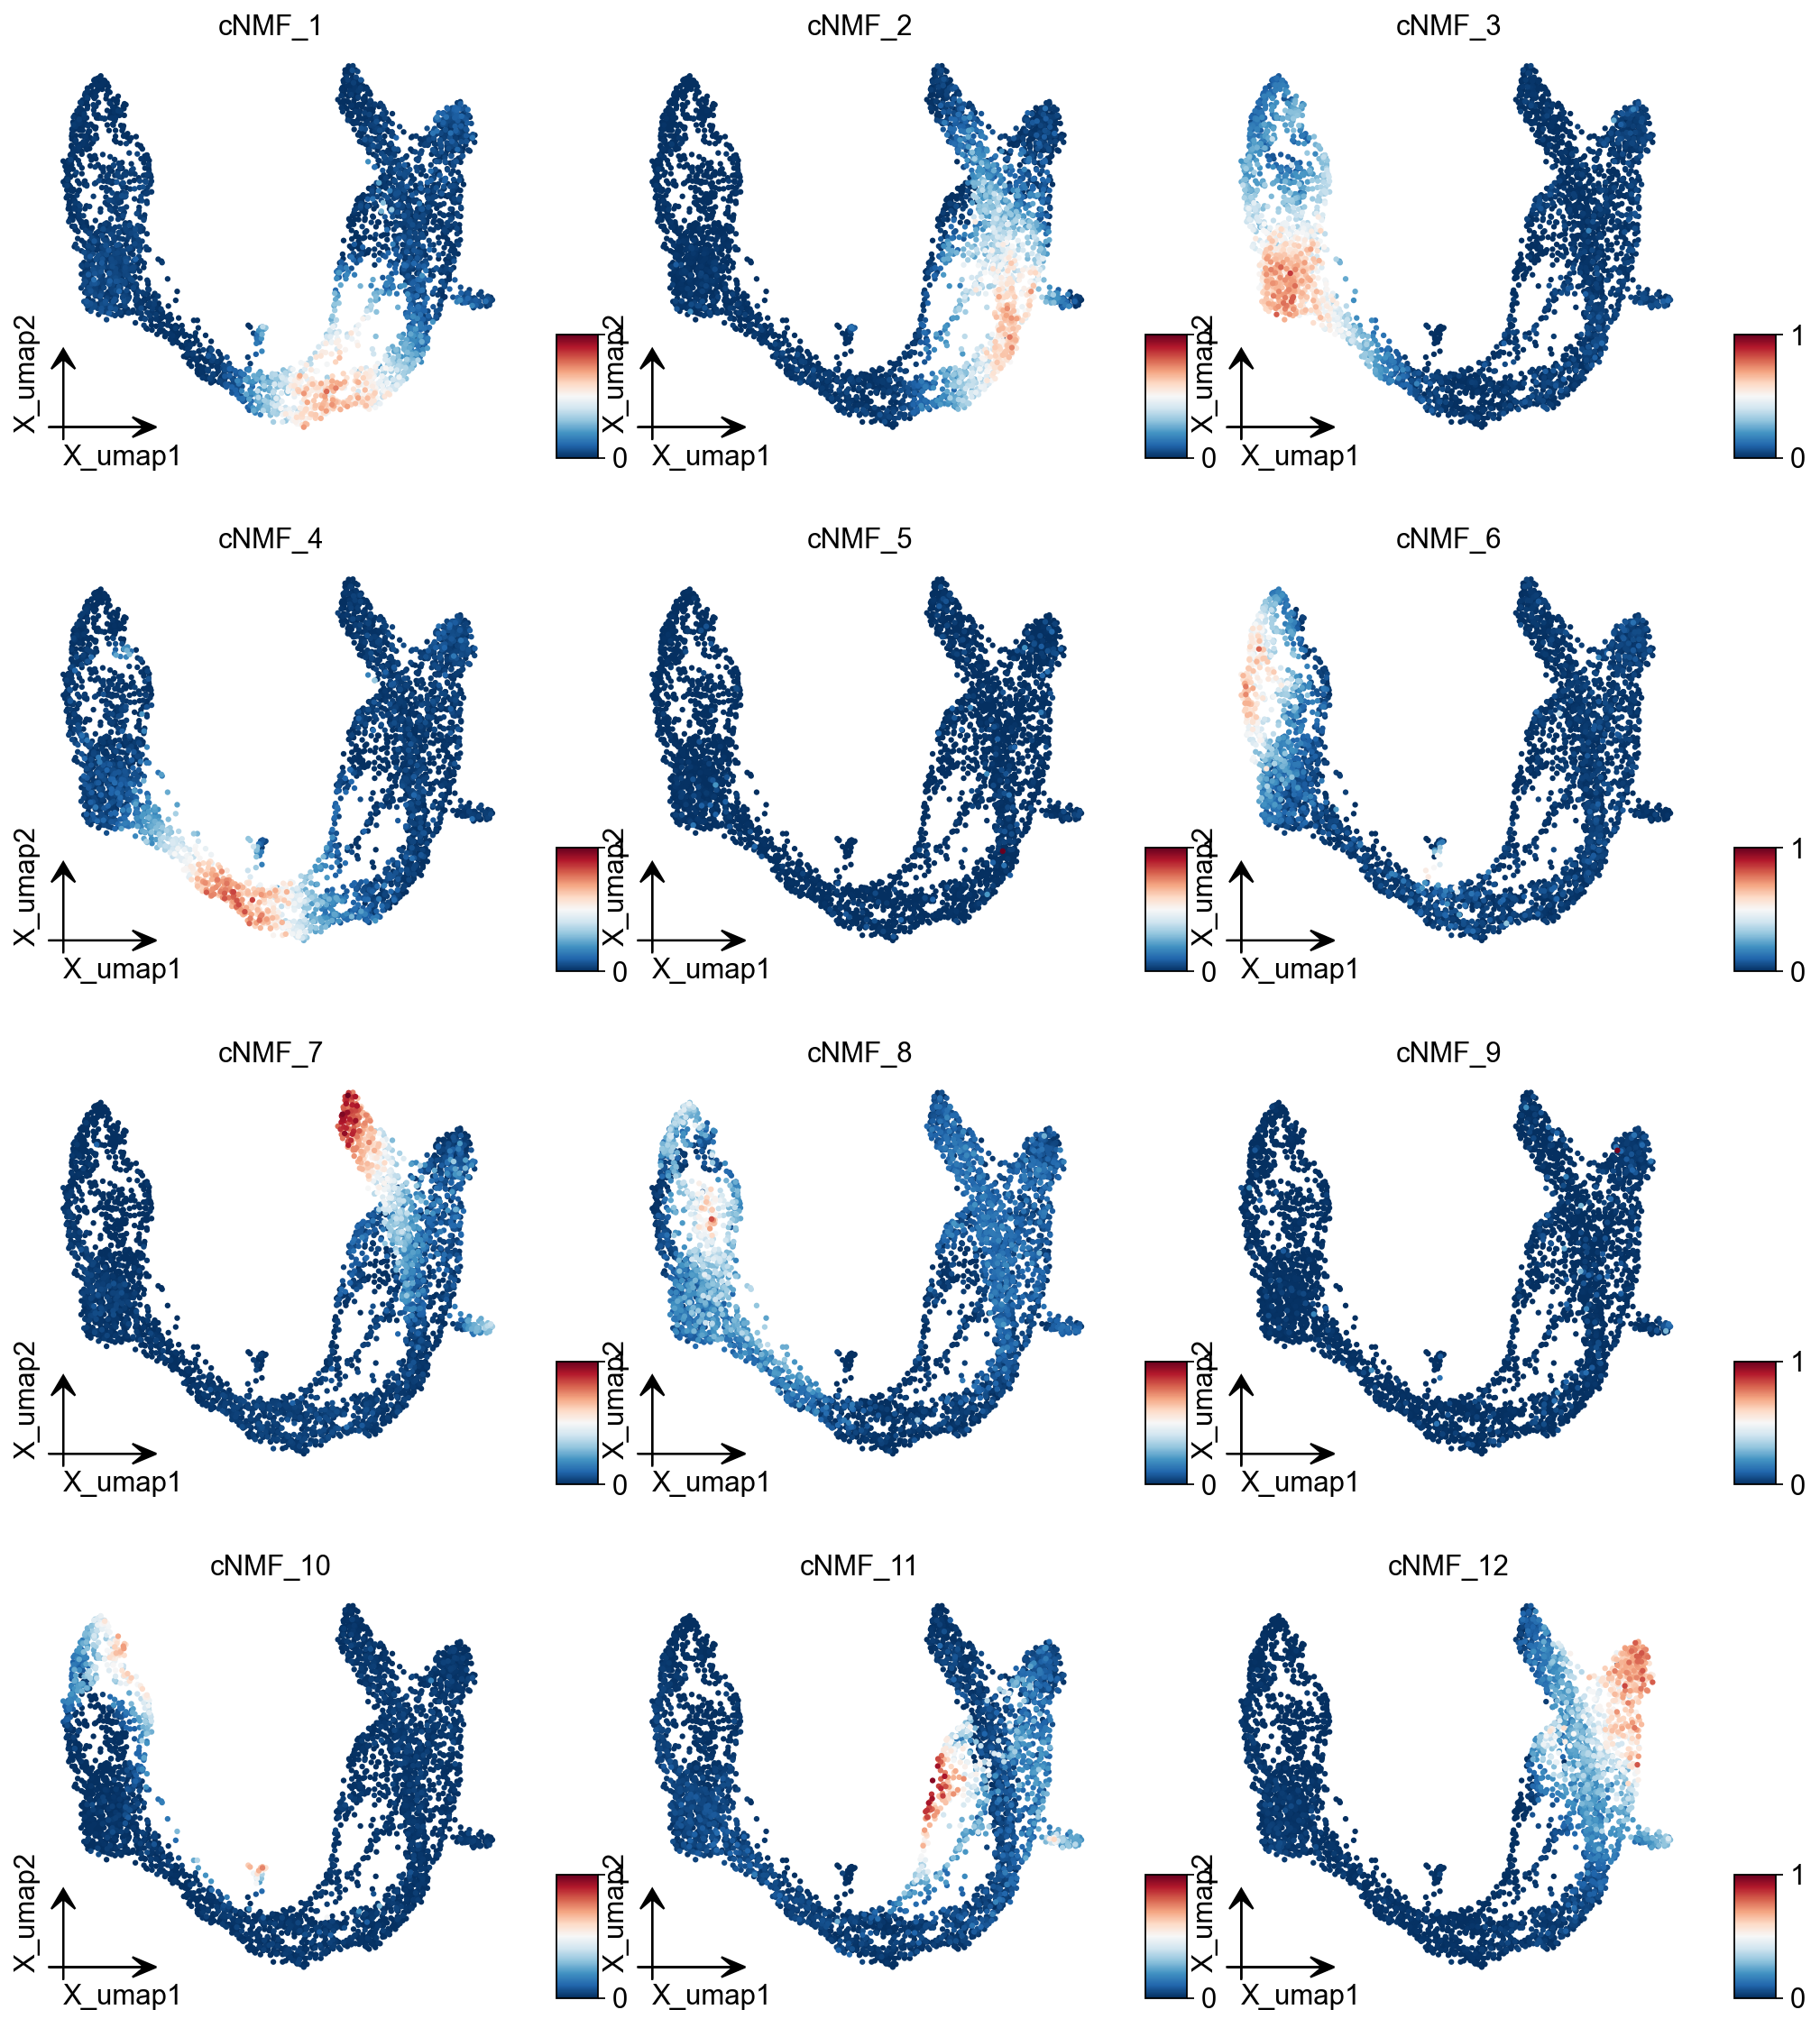

In [25]:
ov.pl.embedding(adata, basis='X_umap',color=result_dict['usage_norm'].columns,
           use_raw=False, ncols=3, vmin=0, vmax=1,frameon='small')

<Axes: title={'center': 'cNMF_cluster'}, xlabel='X_umap1', ylabel='X_umap2'>

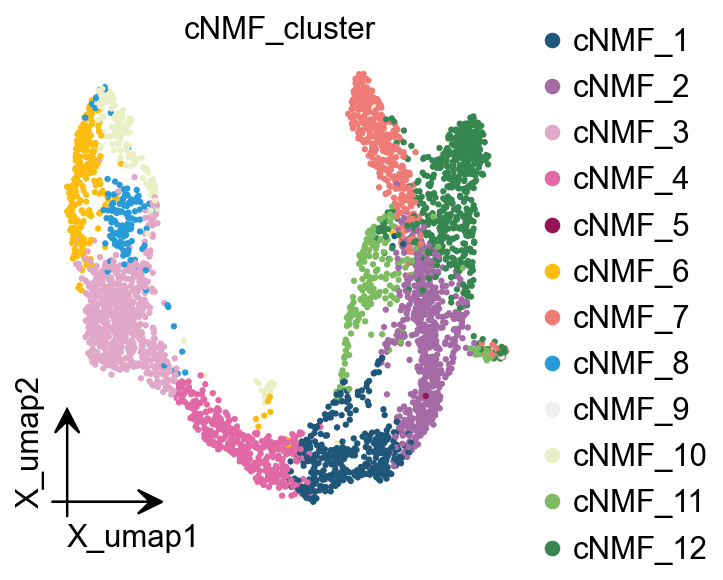

In [26]:
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=['cNMF_cluster'],
    frameon='small',
    #title="Celltypes",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    #size=10,
    #legend_loc=True, 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
)

Here we are, proposing another idea of categorisation. We use cells with cNMF greater than 0.5 as a primitive class, and then train a random forest classification model, and then use the random forest classification model to classify cells with cNMF less than 0.5 to get a more accurate

In [27]:
cnmf_obj.get_results_rfc(adata,result_dict,
                         use_rep='scaled|original|X_pca',
                        cNMF_threshold=0.5)

Single Tree: 0.9555555555555556
Random Forest: 0.9873015873015873
cNMF_cluster_rfc is added to adata.obs
cNMF_cluster_clf is added to adata.obs


[<Axes: title={'center': 'cNMF_cluster_rfc'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'cNMF_cluster_clf'}, xlabel='X_umap1', ylabel='X_umap2'>]

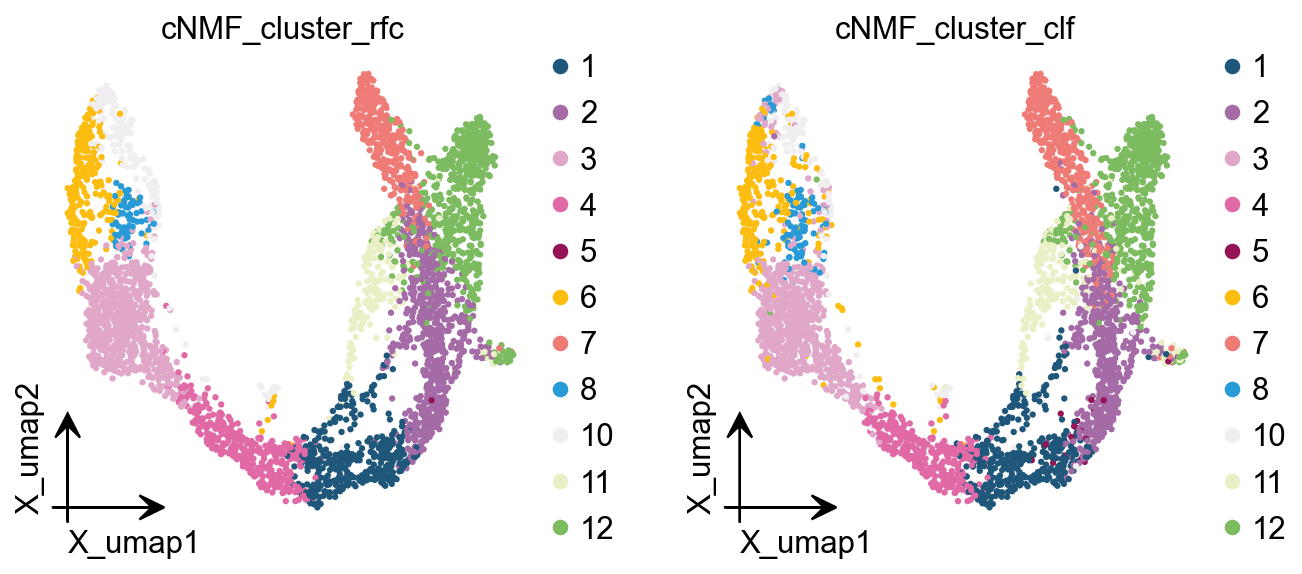

In [28]:
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=['cNMF_cluster_rfc','cNMF_cluster_clf'],
    frameon='small',
    #title="Celltypes",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    #size=10,
    #legend_loc=True, 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
)

In [29]:
plot_genes=[]
for i in result_dict['top_genes'].columns:
    plot_genes+=result_dict['top_genes'][i][:3].values.reshape(-1).tolist()

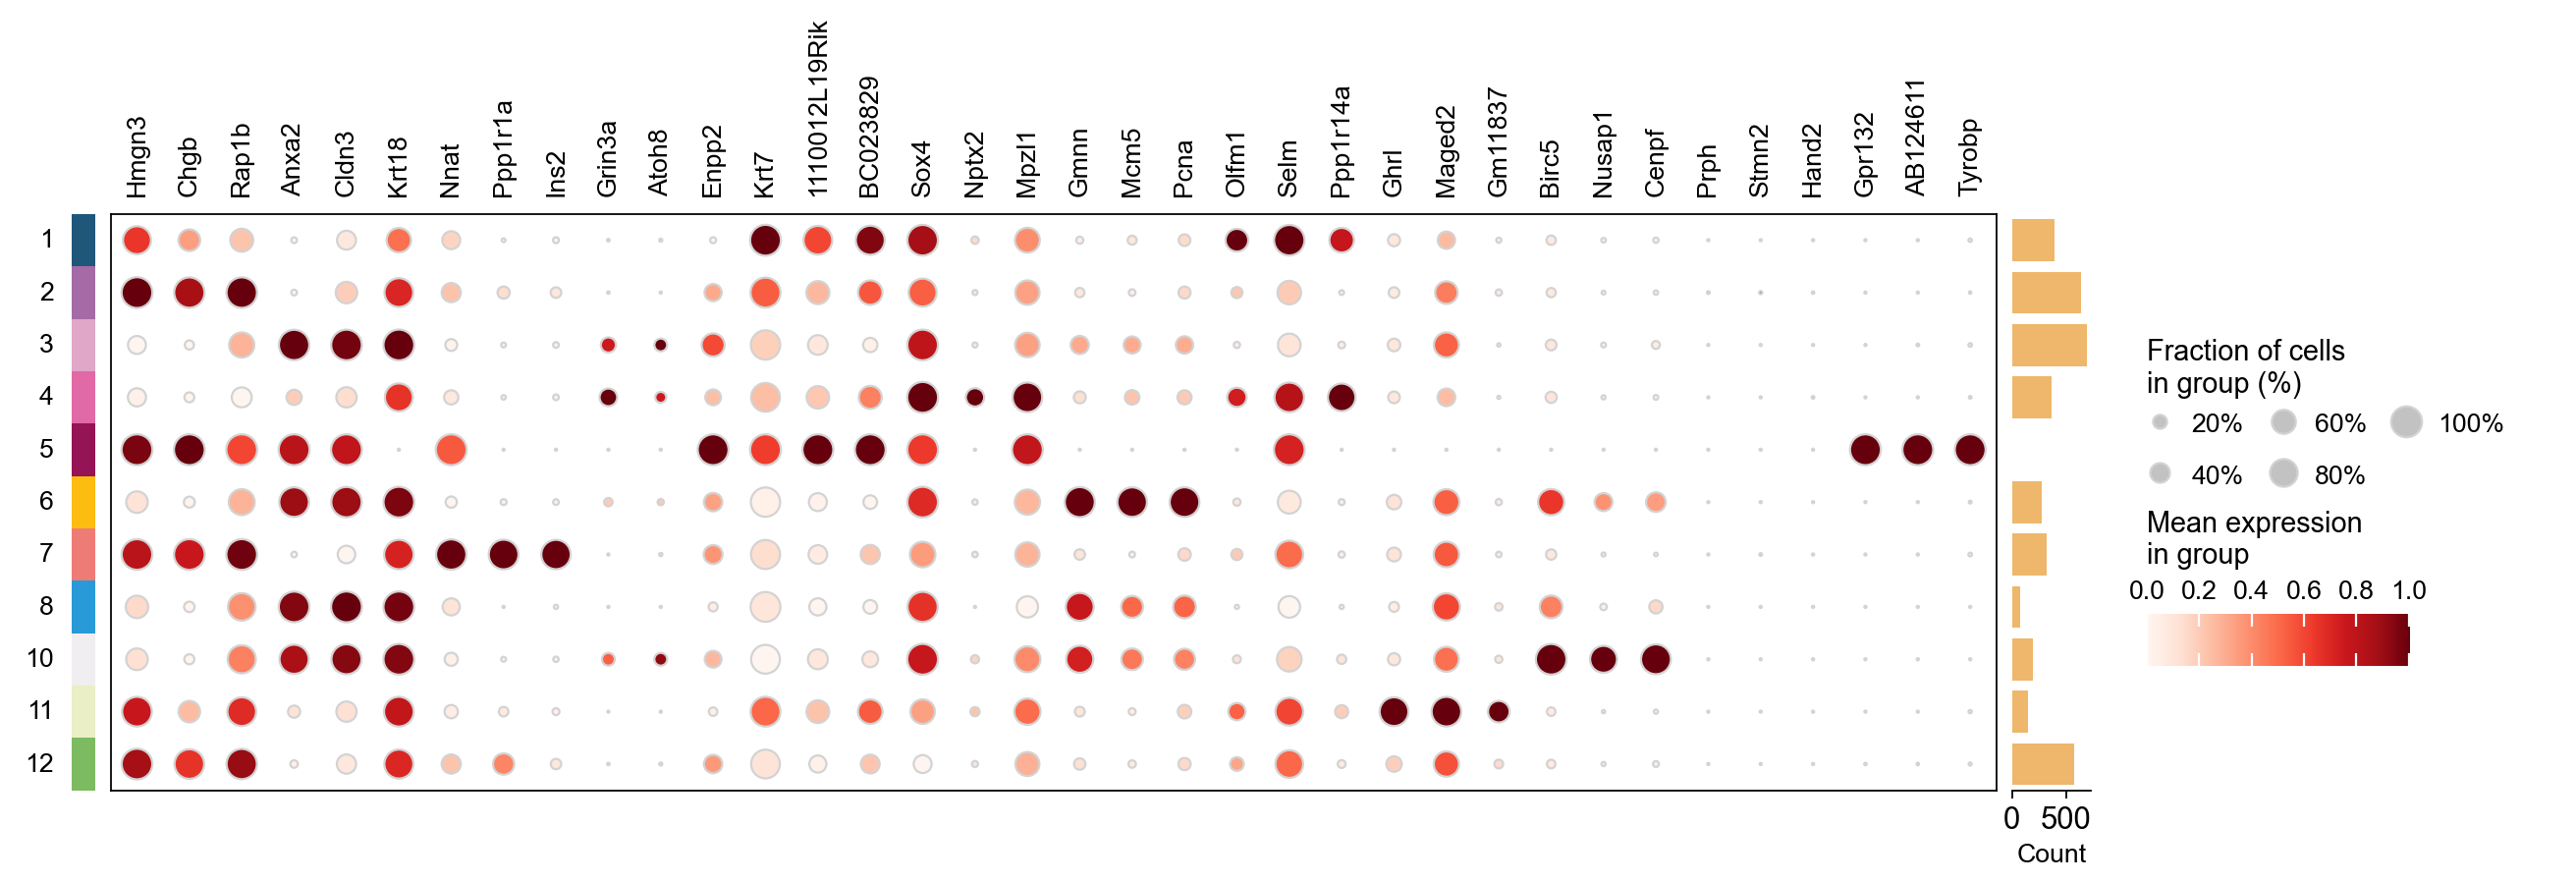

In [30]:
ov.pl.dotplot(
    adata,plot_genes,
    "cNMF_cluster_rfc", dendrogram=False,standard_scale='var',
)

## Hotspot

Hotspot is a tool for identifying informative genes (and gene modules) in a single-cell dataset.

- DeTomaso D, Yosef N. Hotspot identifies informative gene modules across modalities of single-cell genomics. Cell Syst. 2021 May 19;12(5):446-456.e9. doi: 10.1016/j.cels.2021.04.005. Epub 2021 May 4. PMID: 33951459.

In [8]:
# to calculate the total_counts
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [9]:
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
adata.layers["counts_csc"] = adata.layers["counts"].tocsc()
hs = ov.single.Hotspot(
    adata, 
    layer_key="counts_csc", 
    model='danb', 
    latent_obsm_key="X_pca",
    umi_counts_obs_key="total_counts"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

### Determining informative genes

Now we compute autocorrelations for each gene, in the pca-space, to determine which genes have the most informative variation.

In [10]:
hs_results = hs.compute_autocorrelations(jobs=8)

hs_results.head(15)


00%|██████████| 16426/16426 [00:03<00:00, 4998.58it/s]

C           Z  Pval  FDR
Gene                                    
Btbd17   0.735443  221.872382   0.0  0.0
Gadd45a  0.666501  213.692549   0.0  0.0
Neurog3  0.658402  208.855264   0.0  0.0
Spp1     0.806283  200.751152   0.0  0.0
Mdk      0.695210  199.681646   0.0  0.0
Rps19    0.819013  199.041836   0.0  0.0
Gnas     0.701187  192.850484   0.0  0.0
Rpl13    0.817551  192.250551   0.0  0.0
Nnat     0.780046  191.744472   0.0  0.0
Rpl18a   0.780471  191.128396   0.0  0.0
Rpl32    0.796391  190.960143   0.0  0.0
Gcg      0.603454  190.364941   0.0  0.0
Ins2     0.753340  189.588977   0.0  0.0
Ppp1r1a  0.727086  188.885836   0.0  0.0
Rps4x    0.797900  187.245979   0.0  0.0

### Grouping genes into lineage-based modules
To get a better idea of what expression patterns exist, it is helpful to group the genes into modules.

Hotspot does this using the concept of “local correlations” - that is,
correlations that are computed between genes between cells in the same neighborhood.

Here we avoid running the calculation for all Genes x Genes pairs and instead
only run this on genes that have significant autocorrelation to begin with.

The method `compute_local_correlations` returns a Genes x Genes matrix of
Z-scores for the significance of the correlation between genes. This object
is also retained in the `hs` object and is used in the subsequent steps.

In [11]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=8)

Computing pair-wise local correlation on 500 features...




00%|██████████| 124750/124750 [00:03<00:00, 32683.05it/s]

Now that pair-wise local correlations are calculated, we can group genes into modules.

To do this, a convenience method is included `create_modules` which performs
agglomerative clustering with two caveats:

- If the FDR-adjusted p-value of the correlation between two branches exceeds `fdr_threshold`,
then the branches are not merged.
- If two branches are two be merged and they are both have at least min_gene_threshold genes,
then the branches are not merged. Further genes that would join to the resulting merged module
(and are therefore ambiguous) either remain unassigned (if core_only=True) or are assigned to the module with the
smaller average correlations between genes, i.e. the least-dense module (if `core_only=False`)

The output is a Series that maps gene to module number. Unassigned genes are indicated with a module number of `-1`

This method was used to preserved substructure (nested modules) while still giving the analyst
some control. However, since there are a lot of ways to do hierarchical clustering, you can also
manually cluster using the gene-distances in `hs.local_correlation_z`

In [12]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

Module
-1     93
 1     82
 9     47
 4     44
 3     39
 8     37
 6     26
 13    22
 12    21
 11    20
 7     19
 2     19
 5     16
 10    15
Name: count, dtype: int64

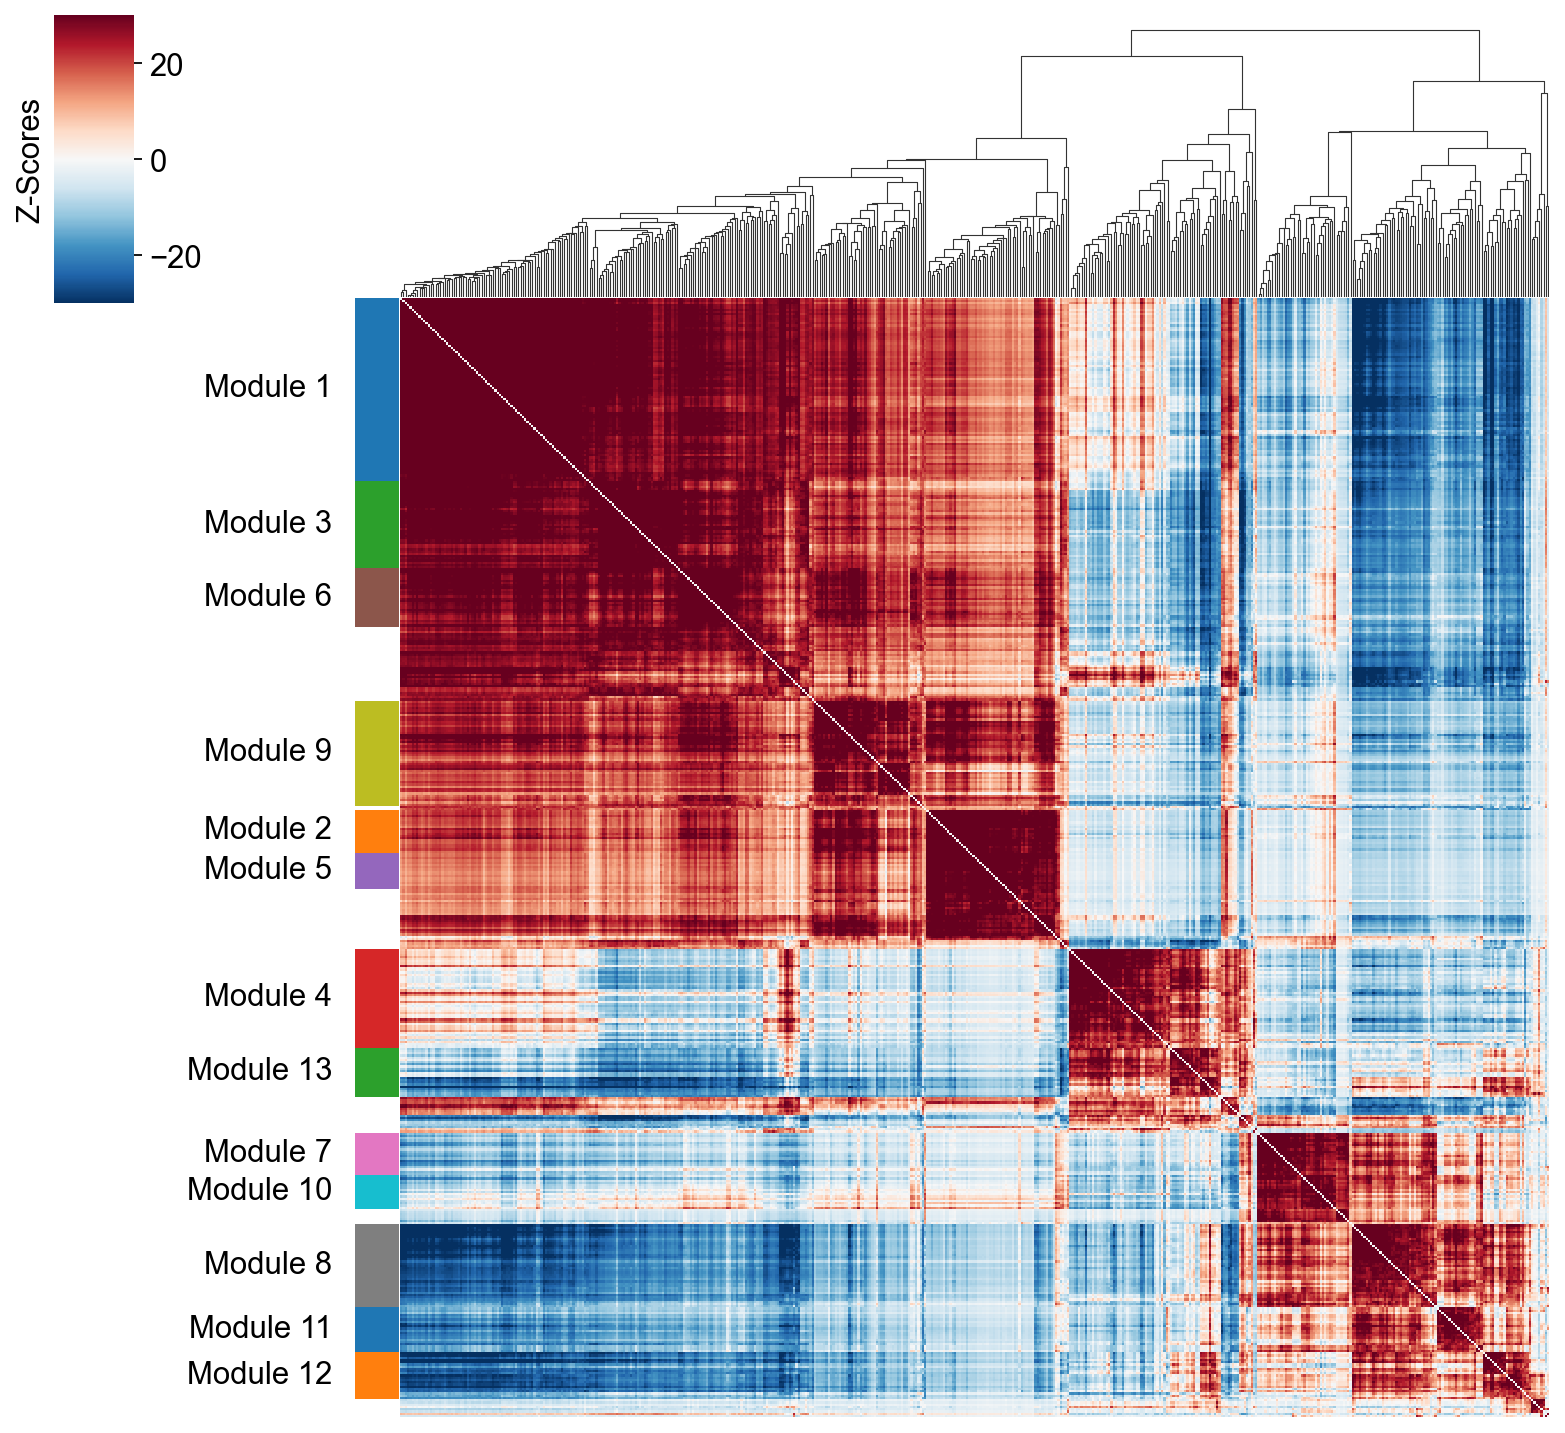

In [14]:
hs.plot_local_correlations(vmin=-30, vmax=30,)

To explore individual genes, we can look at the genes with the top autocorrelation
in a given module as these are likely the most informative.

In [19]:
# Show the top genes for a module

module = 4

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

C           Z  Pval  FDR  Module
Gene                                            
Btbd17   0.735443  221.872382   0.0  0.0     4.0
Gadd45a  0.666501  213.692549   0.0  0.0     4.0
Neurog3  0.658402  208.855264   0.0  0.0     4.0
Mdk      0.695210  199.681646   0.0  0.0     4.0
Tmsb4x   0.628210  187.142300   0.0  0.0     4.0
Neurod2  0.549973  183.843618   0.0  0.0     4.0
Selm     0.601179  178.700916   0.0  0.0     4.0
Smarcd2  0.577830  174.089181   0.0  0.0     4.0
Sox4     0.613079  173.945370   0.0  0.0     4.0
Btg2     0.554990  165.342505   0.0  0.0     4.0

### Summary Module Scores
To aid in the recognition of the general behavior of a module, Hotspot can compute
aggregate module scores.

In [20]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 13 modules...



00%|██████████| 13/13 [00:00<00:00, 30.21it/s]

1         2         3         4         5         6   \
index                                                                           
AAACCTGAGAGGGATA  -6.583796 -1.093584 -3.131375 -2.099180 -0.819142 -2.400016   
AAACCTGAGCCTTGAT   7.663903 -0.765588  6.610663 -2.388122 -0.689135  2.296545   
AAACCTGAGGCAATTA  -6.066218 -1.212847 -3.005648 -2.684893 -0.703958 -2.226183   
AAACCTGCATCATCCC  11.594423  4.786089  5.015609 -2.241397  0.848967  8.482152   
AAACCTGGTAAGTGGC  -3.090054 -1.036188 -3.197947  5.563916 -0.793746 -2.413544   

                        7         8          9         10        11        12  \
index                                                                           
AAACCTGAGAGGGATA -0.451105  2.504838  -2.298986 -1.439230 -0.739708  3.368700   
AAACCTGAGCCTTGAT -1.217827 -3.391921   0.921212 -0.813991 -1.694216 -2.358554   
AAACCTGAGGCAATTA -0.702572  2.636014  -2.243965 -0.119376  0.899747  2.736469   
AAACCTGCATCATCCC -0.886003 -3.327994  12.943623  0.456323 -1.689177 -2.565122   
AAACCTGGTAAGTGGC -1.378844 -2.149192  -2.072845 -2.134279 -1.460957 -0.137338   

                        13  
index                       
AAACCTGAGAGGGATA  0.531080  
AAACCTGAGCCTTGAT -2.625691  
AAACCTGAGGCAATTA -0.274772  
AAACCTGCATCATCCC -2.858705  
AAACCTGGTAAGTGGC  6.417286

In [21]:
module_cols = []
for c in module_scores.columns:
    key = f"Module_{c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

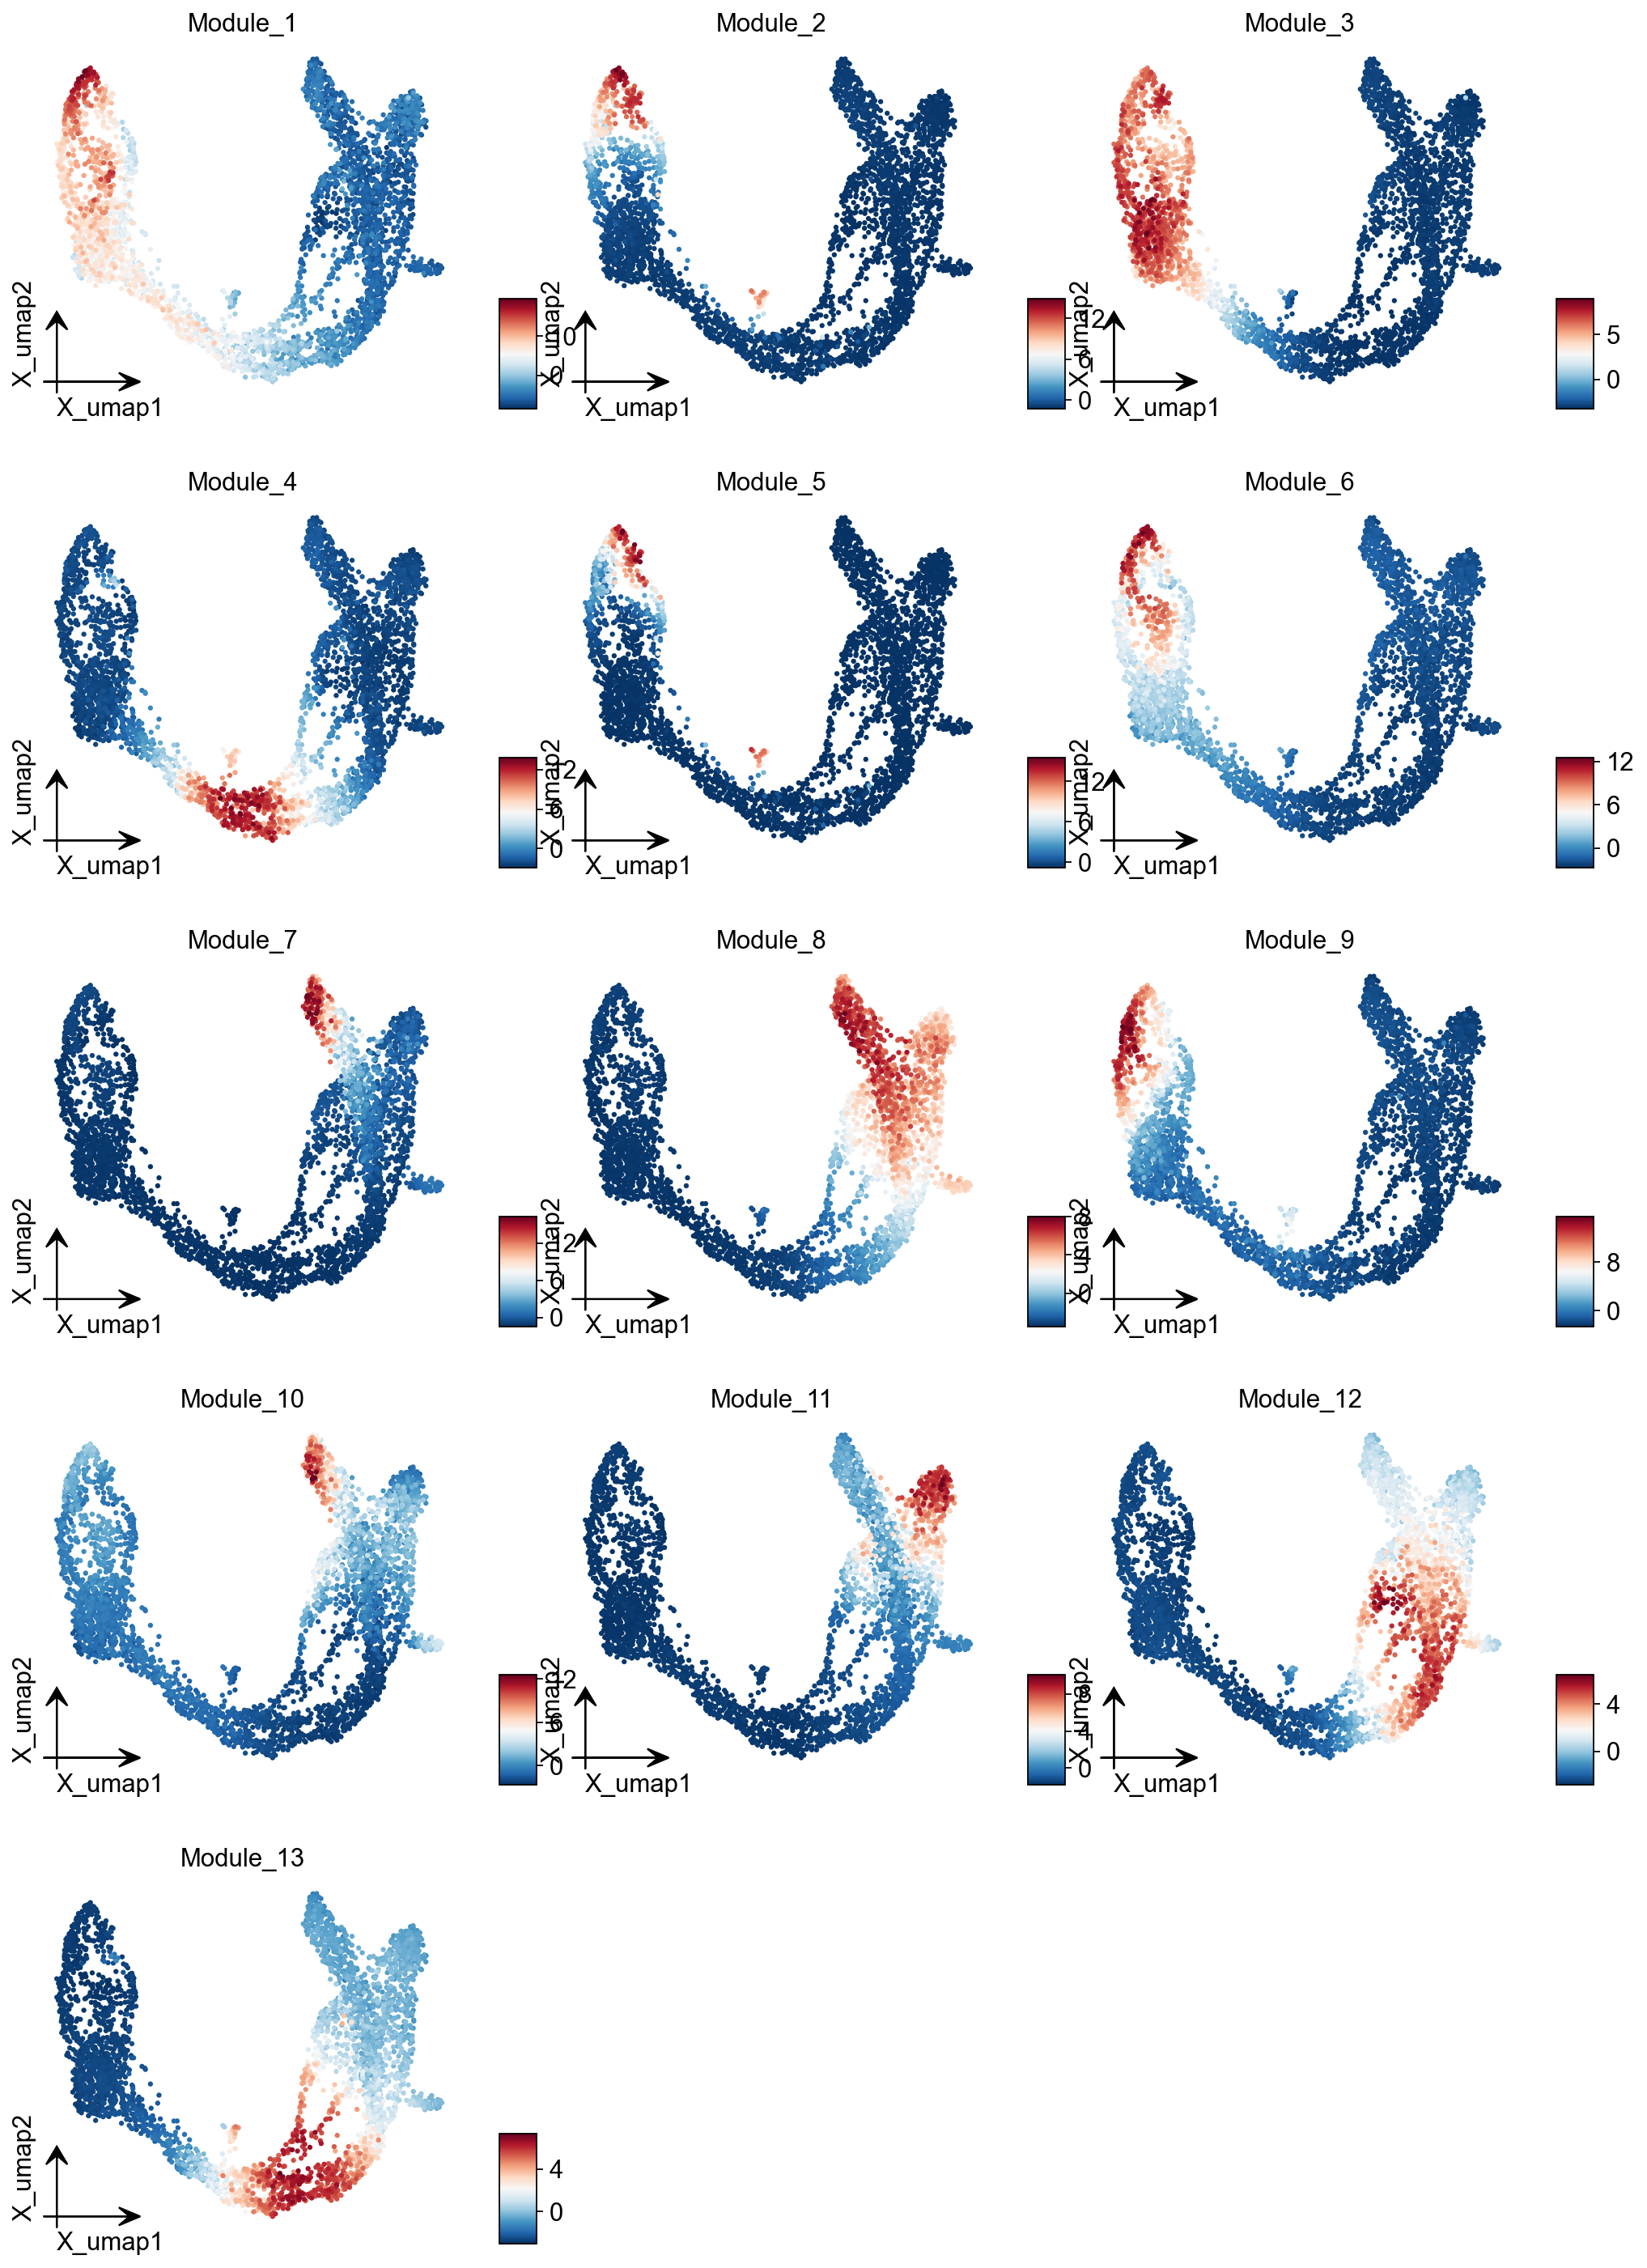

In [23]:
ov.pl.embedding(adata, basis='X_umap',color=module_cols,
           use_raw=False, ncols=3, frameon='small')